In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import brainstate
import brainunit as u
from scipy.integrate import solve_ivp

def newton_method(f, y0, t, dt, tol=1e-6, max_iter=1, order = 2, modified = False, args=()):

    def g(t, y, *args):
        if order == 1:
            return y - y0 - dt * f(t + dt, y, *args)
        elif order == 2:
            return y - y0 - 0.5*dt * (f(t, y0, *args) + f(t + dt, y, *args))
        else:
            raise ValueError("Only order 1 or 2 is supported.")

    def cond_fun(carry):
        i, _, A, df = carry
        condition = jnp.logical_or(jnp.linalg.norm(A) < tol, jnp.linalg.norm(df) < tol)
        return jnp.logical_and(i < max_iter, jnp.logical_not(condition))

    def body_fun(carry):
        i, y1, _, _ = carry
        A, df = brainstate.augment.jacfwd(lambda y: g(t, y, *args), return_value=True, has_aux=False)(y1)
        new_y1 = y1 - jnp.linalg.solve(A, df)
        return (i + 1, new_y1, A, df)

    def body_fun_modified(carry):
        i, y1, A, _ = carry
        df = g(t, y1, *args)
        new_y1 = y1 - jnp.linalg.solve(A, df)
        return (i + 1, new_y1, A, df)
    
    dt = u.get_magnitude(dt)
    init_guess = y0 + dt*f(t, y0, *args)
    A, df= brainstate.augment.jacfwd(lambda y: g(t, y, *args), return_value=True, has_aux=False)(init_guess)
    init_carry = (0, init_guess, A, df)

    if modified ==True:
        _, result, _, _ = jax.lax.while_loop(cond_fun, body_fun_modified, init_carry)
    else:
        _, result, _, _ = jax.lax.while_loop(cond_fun, body_fun, init_carry)
        
    return result

def solve_ivp_method(f, y0, t, dt, method, args=()):
    sol = solve_ivp(lambda t, y: f(t, y, *args), [t, t+dt], y0, t_eval=[t + dt], method=method)
    return sol.y.flatten()

In [2]:
def error_analysis(f, y0, t_start, t_end, dt, true_solution_func):

    num_steps = int((t_end - t_start) / dt)
    t_values = jnp.linspace(t_start, t_end, num_steps + 1)
    y_true = true_solution_func(t_values)

    y_numerical = [y0]
    y_current = y0
    for i in range(num_steps):
        t = t_values[i]
        y_current = newton_method(f, y_current, t, dt, order= 1, modified=True)
        y_numerical.append(y_current)
    y_numerical = jnp.array(y_numerical).flatten()
    custom_errors = jnp.abs(y_true - y_numerical)


    ## solve_ivp_method
    y_numerical = [y0]
    y_current = y0
    errors = {}
    methods = ['RK23', 'RK45', 'DOP853', 'Radau', 'BDF', 'LSODA']
    for method in methods:
        y_numerical = [y0]
        y_current = y0
        for i in range(num_steps):
            t = t_values[i]
            y_current =  solve_ivp_method(f, y_current, t, dt,method=method)
            y_numerical.append(y_current)
        y_numerical = jnp.array(y_numerical).flatten()
        error =  jnp.abs(y_true - y_numerical)
        errors[method] = error


    plt.figure(figsize=(10, 6))
    plt.plot(t_values, custom_errors, label='Newton method', color='red')
    for method, error in errors.items():
        plt.plot(t_values, error, label=method)
    plt.xlabel('Time (t)')
    plt.ylabel('Global Error')
    plt.title('Error Comparison of Different Numerical Solvers')
    plt.legend()
    plt.grid(True)
    plt.show()


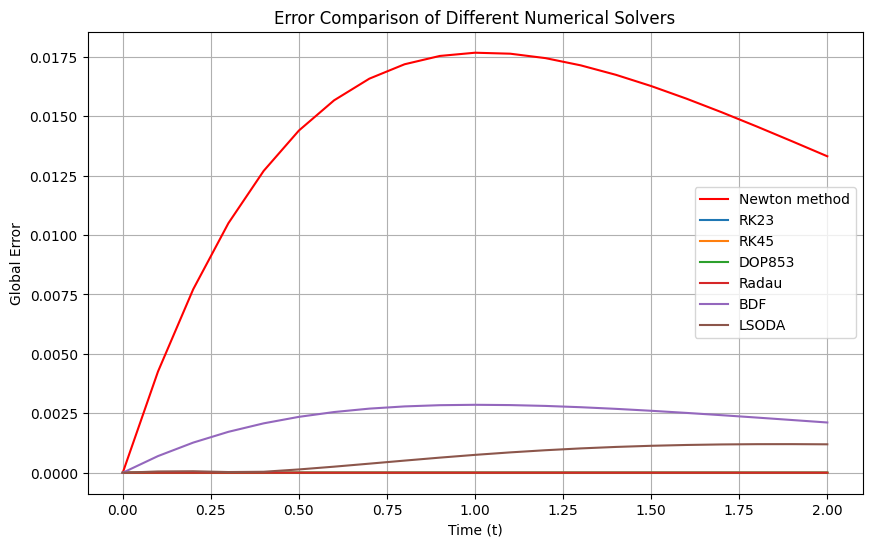

In [5]:
def f(t, y):
    return -1*y

def true_solution(t):
    return jnp.exp(-1*t)

y0 = jnp.array([1.0])
t_start = 0.0
t_end = 2.0
dt = 0.1

error_analysis(f, y0, t_start, t_end, dt, true_solution)

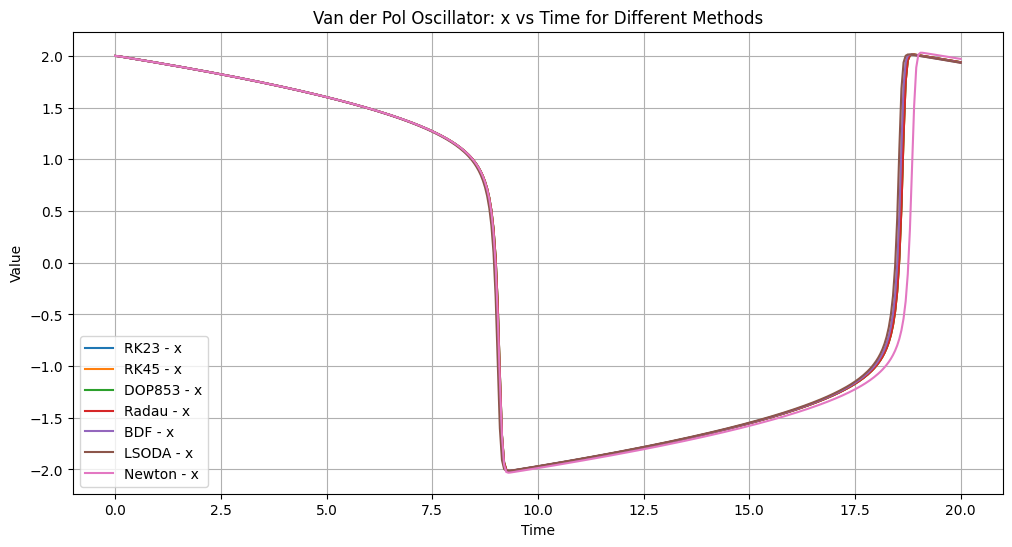

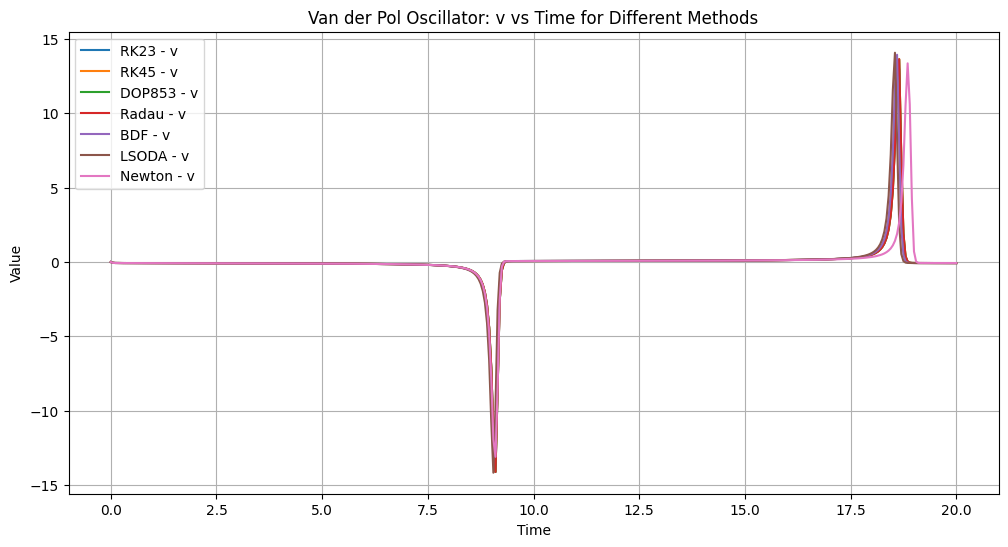

In [4]:
def f(t, y, mu):
    x, v = y
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return jnp.array([dxdt, dvdt])
y0 = jnp.array([2.0, 0.0])
t_start = 0.0
t_end = 20.0
dt = 0.05
mu = 10.0

num_steps = int((t_end - t_start) / dt)
t_values = jnp.linspace(t_start, t_end, num_steps + 1)

methods = ['RK23', 'RK45', 'DOP853', 'Radau', 'BDF', 'LSODA', 'Newton']
results = {}

for method in methods:
    y_current = y0
    y_vals = [y_current]
    if method == 'Newton':
        for i in range(num_steps):
            t = t_values[i]
            y_current = newton_method(f, y_current, t, dt, order=2, modified=False, args=(mu,))
            y_vals.append(y_current)
    else:
        for i in range(num_steps):
            t = t_values[i]
            y_current = solve_ivp_method(f, y_current, t, dt, method, args=(mu,))
            y_vals.append(y_current)

    results[method] = jnp.array(y_vals)

plt.figure(figsize=(12, 6))
for method, result in results.items():
    x_values = result[:, 0]
    plt.plot(t_values, x_values, label=f'{method} - x')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Van der Pol Oscillator: x vs Time for Different Methods')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for method, result in results.items():
    v_values = result[:, 1]
    plt.plot(t_values, v_values, label=f'{method} - v')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Van der Pol Oscillator: v vs Time for Different Methods')
plt.legend()
plt.grid(True)
plt.show()

